# Spring 2018 TR-GY 7133 Assignment 2: Bus Scheduling

## Author: Yuwen Chang (NYU CUSP 2018)

## Coded in Python 3

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import datetime as dt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Timetables

|period ( $j$ )|$d_{oj}$|$P_{mj}$|$F_j^2$ (veh/hr)|$H_j^2$ (min)|
|---|---|---|---|---|
|6-7 am|50| 90|2.00|30|
|7-8 am|60|468|7.80| 8|
|8-9 am|60|388|6.47| 9|

## 1.a Even Headway Timetable

In [2]:
# input hourly cumulative vehicles and calculated schedule based on method 2
tm = ["06:00", "07:00", "08:00", "09:00"]
veh = [1, 3, 10.8, 17.27]
sch = ["06:30", "07:00", "07:08", "07:16", "07:24", "07:32", "07:40", "07:48",
       "07:56", "08:02", "08:11", "08:20", "08:29", "08:38", "08:47", "08:56"]

In [3]:
# create dataframe with proper time format
df1 = pd.DataFrame({"time":tm, "veh":veh})
df2 = pd.DataFrame({"time":sch})
df1["time"] = pd.to_datetime(df1["time"])
df2["time"] = pd.to_datetime(df2["time"])

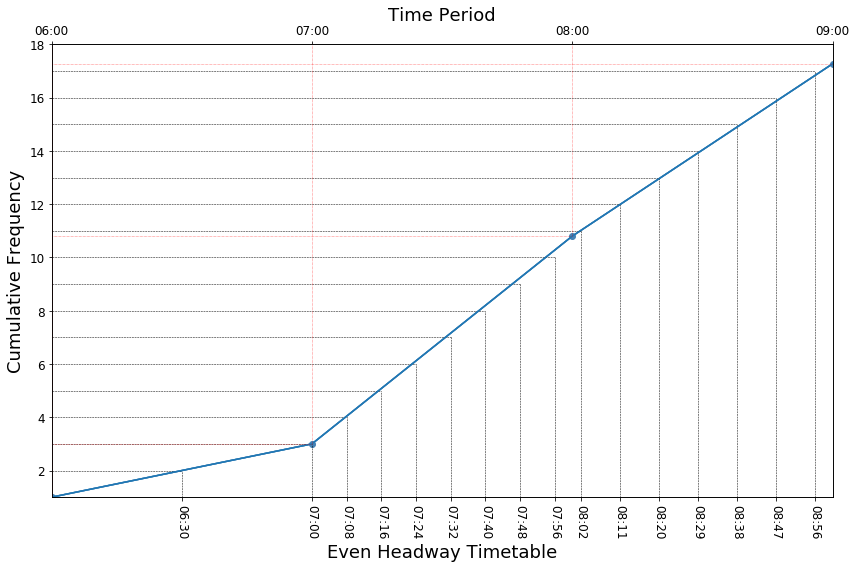

In [4]:
# plot even headway timetable
fig = pl.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(df1["time"], df1["veh"])
ax2.plot(df1["time"], df1["veh"])
ax1.plot(df1["time"], df1["veh"], color="steelblue", marker='o')

for i in arange(len(df2)):
    ax1.plot([df2["time"][i],df2["time"][i]], [0,i+2], 'k--', lw=0.5)
    ax1.plot([df1["time"][0],df2["time"][i]], [i+2,i+2], 'k--', lw=0.5)

for i in arange(len(df1)):
    ax2.plot([df1["time"][i],df1["time"][i]], [20,df1["veh"][i]], 'r:', lw=0.5)
    ax2.plot([df1["time"][0],df1["time"][i]], [df1["veh"][i],df1["veh"][i]], 'r:', lw=0.5)

ax1.set_xticks([str(i)[:-3] for i in df2["time"].dt.time])
ax1.set_xticklabels([str(i)[:-3] for i in df2["time"].dt.time],
                    fontsize=12, rotation=270)
ax1.set_yticks(arange(0,21,2))
ax1.set_yticklabels(arange(0,21,2), fontsize=12)
ax1.set_xlabel("Even Headway Timetable", fontsize=18)
ax1.set_ylabel("Cumulative Frequency", fontsize=18)

ax2.set_xticks([str(i) for i in df1["time"].dt.time])
ax2.set_xticklabels([str(i)[:-3] for i in df1["time"].dt.time], fontsize=12)
ax2.set_xlabel("Time Period", fontsize=18)

# pl.title("Fig. 1: Even Headway Schedule from 06:00 to 09:00", fontsize=20)
ax1.set_xlim("06:00:00", "09:00:00")
ax2.set_xlim("06:00:00", "09:00:00")
pl.ylim(1, 18)

pl.savefig("AS2_fig1.png", dpi=300)
pl.tight_layout()
pl.show()

## 1.b Even Average Load Timetable

In [5]:
# input observed bus load based on method 2
tstamp = ["06:00", "06:15", "06:45", "07:05", "07:15", "07:25", "07:35",
          "07:45", "07:55", "08:08", "08:17", "08:26", "08:35", "08:50"]
load = [0, 42, 48, 42, 93, 80, 105, 99, 49, 37, 102, 59, 34, 156]

In [6]:
# create dataframe with proper time format and calculated cumulative load
df = pd.DataFrame({"time":tstamp, "load":load})
#df["time"] = pd.to_datetime(df["time"]).dt.time
df["time"] = pd.to_datetime(df["time"])
df["cum_load"] = [sum(df["load"][0:i+1]) for i in arange(14)]
df

,load,time,cum_load
0,0,2018-02-26 06:00:00,0
1,42,2018-02-26 06:15:00,42
2,48,2018-02-26 06:45:00,90
3,42,2018-02-26 07:05:00,132
4,93,2018-02-26 07:15:00,225
5,80,2018-02-26 07:25:00,305
6,105,2018-02-26 07:35:00,410
7,99,2018-02-26 07:45:00,509
8,49,2018-02-26 07:55:00,558
9,37,2018-02-26 08:08:00,595


In [7]:
# calculate time differences
#tdiff = np.diff(df["time"])
#tdiff = tdiff.astype('timedelta64[m]')
tdiff = np.diff(df["time"]) / 60000000000
tdiff = tdiff.astype("int")
#tdiff = np.append(tdiff, 10)
tdiff

array([15, 30, 20, 10, 10, 10, 10, 10, 13,  9,  9,  9, 15])

In [8]:
# calculate load differences
ldiff = np.array(load[1:])
ldiff

array([ 42,  48,  42,  93,  80, 105,  99,  49,  37, 102,  59,  34, 156])

In [9]:
# calculate segmented slopes
slope = ldiff / tdiff
slope

array([ 2.8       ,  1.6       ,  2.1       ,  9.3       ,  8.        ,
       10.5       ,  9.9       ,  4.9       ,  2.84615385, 11.33333333,
        6.55555556,  3.77777778, 10.4       ])

In [74]:
# calculate even average load timetable
vehicle = 1
cum_min = 0
cum_load = 0
schedule = []
bus_load = []

# calculate cumulative load for respective slope segment
for i,s in enumerate(slope):

    # iterate cumulative load by minute
    for j in arange(tdiff[i]):
        cum_min += 1
        cum_load += s
        
        # insert new vehicle for each desired occupancy (before 7 am)
        if (cum_min <= 60) and (cum_load >= (50 * vehicle)):
            print(vehicle, cum_min, cum_load, s)
            vehicle += 1
            schedule.append(cum_min)
            bus_load.append(cum_load)

        # insert new vehicle for each desired occupancy (after 7 am)
        if (cum_min > 60) and (cum_load >= (60 * vehicle - 20)):
            print(vehicle, cum_min, cum_load, s)
            vehicle += 1
            schedule.append(cum_min)
            bus_load.append(cum_load)

1 20 50.0 1.6
2 50 100.49999999999989 2.1
3 69 169.19999999999985 9.3
4 75 224.99999999999991 9.3
5 82 280.9999999999999 8.0
6 89 346.9999999999999 10.5
7 95 409.9999999999999 10.5
8 101 469.39999999999975 9.9
9 108 523.6999999999996 4.9
10 123 580.7692307692299 2.8461538461538463
11 132 640.3333333333325 11.333333333333334
12 138 703.5555555555549 6.555555555555555
13 148 763.5555555555549 3.7777777777777777
14 158 821.1999999999996 10.4
15 164 883.5999999999995 10.4
16 170 945.9999999999993 10.4


In [11]:
# transform cumulative minutes to regular time format
sch_min = np.array(schedule) % 60
sch_hr = np.array(schedule) // 60 + 6
sch2 = list(zip(sch_hr, sch_min))
sch2 = [dt.time(i[0], i[1]) for i in sch2]
sch2

[datetime.time(6, 20),
 datetime.time(6, 50),
 datetime.time(7, 9),
 datetime.time(7, 15),
 datetime.time(7, 22),
 datetime.time(7, 29),
 datetime.time(7, 35),
 datetime.time(7, 41),
 datetime.time(7, 48),
 datetime.time(8, 3),
 datetime.time(8, 12),
 datetime.time(8, 18),
 datetime.time(8, 28),
 datetime.time(8, 38),
 datetime.time(8, 44),
 datetime.time(8, 50)]

In [12]:
# list cumulative loads of buses for plotting horizontal lines
cl = [50,100] + list(arange(160,945,60))
cl

[50, 100, 160, 220, 280, 340, 400, 460, 520, 580, 640, 700, 760, 820, 880, 940]

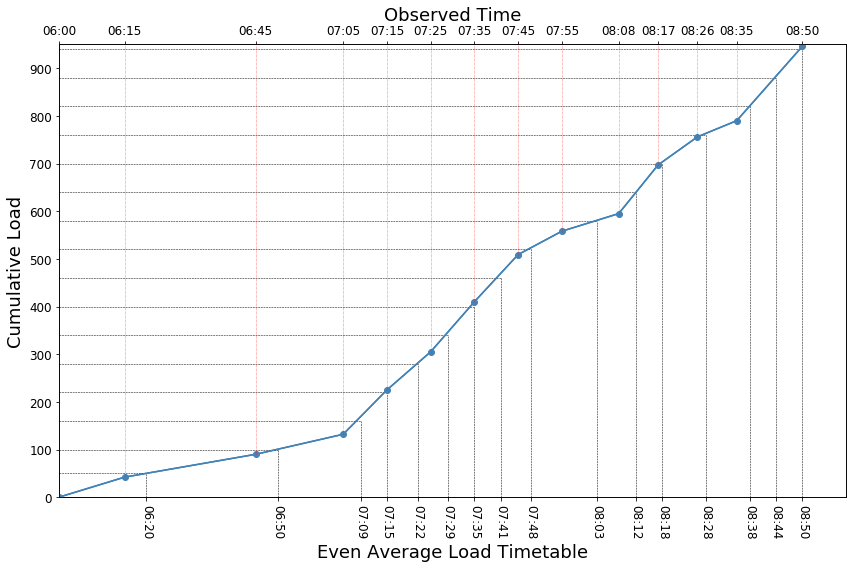

In [13]:
# plot even average load timetable
fig = pl.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(df["time"].dt.time, df["cum_load"])
ax2.plot(df["time"].dt.time, df["cum_load"], color="steelblue", marker='o')

for i in arange(len(sch2)):
    ax1.plot([sch2[i],sch2[i]], [0,cl[i]], 'k--', lw=0.5)
    ax1.plot([dt.time(6,0),sch2[i]], [cl[i],cl[i]], 'k--', lw=0.5)
for i in arange(len(df)):
    ax2.plot([df["time"].dt.time[i],df["time"].dt.time[i]], [950,df["cum_load"][i]], 'r:', lw=0.5)
    
ax1.set_xticks(sch2)
ax1.set_xticklabels([str(i)[:-3] for i in sch2], fontsize=12, rotation=270)
ax1.set_yticks(arange(0,950,100))
ax1.set_yticklabels(arange(0,950,100), fontsize=12)
ax1.set_xlabel("Even Average Load Timetable", fontsize=18)
ax1.set_ylabel("Cumulative Load", fontsize=18)

ax2.set_xticks([str(i) for i in df["time"].dt.time])
ax2.set_xticklabels([str(i)[:-3] for i in df["time"].dt.time], fontsize=12)
ax2.set_xlabel("Observed Time", fontsize=18)

#pl.title("Fig. 2: Even Average Load Schedule from 06:00 to 08:50", fontsize=20)
ax1.set_xlim("06:00:00", "09:00:00")
ax2.set_xlim("06:00:00", "09:00:00")
pl.ylim(0,950)

pl.savefig("AS2_fig2.png", dpi=300)
pl.tight_layout()
pl.show()

#ax.xaxis.tick_top()
#ax.xaxis.set_label_position("bottom")
#ax.tick_params(labeltop=True, labelbottom=False)
#ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)

## 1.c Timetable Comparison

In [14]:
# extract both timetables
ehtt = list(df2["time"].dt.time)
ealtt = sch2

# add initial bus at 6 am
ehtt.append(dt.time(6, 0))
ealtt.append(dt.time(6, 0))

# add interpolated schedule before 9 for even average load timetable
ealtt.append(dt.time(8, 56))

# ehtt = [str(i)[:-3] for i in list(df2["time"].dt.time)]
# ealtt = [str(i)[:-3] for i in sch2]

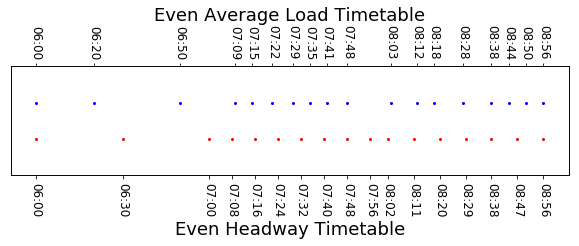

In [20]:
# plot timetable comparison
fig = pl.figure(figsize=(10,2))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(ehtt, np.ones(len(ehtt)), "ro", markersize=2)
ax2.plot(ealtt, np.ones(len(ealtt))+1, "bo", markersize=2)

ax1.set_xticks(ehtt)
ax1.set_xticklabels([str(i)[:-3] for i in ehtt], fontsize=12, rotation=270)
ax1.set_xlabel("Even Headway Timetable", fontsize=18)

ax2.set_xticks(ealtt)
ax2.set_xticklabels([str(i)[:-3] for i in ealtt], fontsize=12, rotation=270)
ax2.set_xlabel("Even Average Load Timetable", fontsize=18)

pl.ylim(0,3)
pl.yticks([], [])

pl.savefig("AS2_fig3.png", dpi=300, bbox_inches='tight')
pl.show()

In [72]:
# calculate average wait time
176/16, 176/17

# ehtt2 = [dt.datetime.strptime(str(i), "%H:%M:%S") for i in ehtt]
# ealtt2 = [dt.datetime.strptime(str(i), "%H:%M:%S") for i in ealtt]

# ehtt3 = [i.seconds / 60 for i in np.diff(ehtt2)]
# ehtt3.pop(-1)
# ehtt3.append(30)
# np.mean(ehtt3)

# ealtt3 = [i.seconds / 60 for i in np.diff(ealtt2)]
# ealtt3.pop(-1)
# ealtt3.pop(-1)
# ealtt3.append(6)
# ealtt3.append(20)
# np.mean(ealtt3)

(11.0, 10.352941176470589)

||Even Headway|Even Average Load|
|---|---|---|
|# of departures (each j)|17 (2, 7, 7)|18 (2, 7, 8)|
|Avg. wait time (min)|11.0|10.4|
|Empty seat-km|2,281|2,641|
|Overcrowded pax-km|67.2|67.2|


In [83]:
# input period average load
df4 = pd.read_csv("AS2-1c.csv")
df4

,dist,A,B,C
0,2.2,72,161,65
1,0.8,90,328,199
2,1.4,85,468,365
3,0.6,68,397,388
4,1.0,54,286,140


In [84]:
# input average frequency by period
f_eh = np.array([2, 7, 7])
f_eal = np.array([2, 7, 8])
doj = np.array([50, 60, 60])

In [86]:
# calculate seat capacity by period
cap_eh = f_eh * doj
cap_eal = f_eal * doj

In [98]:
empty_km_eh_A = np.sum((cap_eh[0] - df4["A"]) * df4["dist"])
empty_km_eh_B = np.sum((cap_eh[1] - df4["B"]) * df4["dist"])
empty_km_eh_C = np.sum((cap_eh[2] - df4["C"]) * df4["dist"])
np.sum([empty_km_eh_A, empty_km_eh_B, empty_km_eh_C]) + 48 * 1.4

2281.0

In [101]:
empty_km_eal_A = np.sum((cap_eal[0] - df4["A"]) * df4["dist"])
empty_km_eal_B = np.sum((cap_eal[1] - df4["B"]) * df4["dist"])
empty_km_eal_C = np.sum((cap_eal[2] - df4["C"]) * df4["dist"])
np.sum([empty_km_eal_A, empty_km_eal_B, empty_km_eal_C]) + 48 * 1.4

2641.0

In [82]:
# excessive pax for even average load timetable
np.sum(np.array(bus_load) - np.array(cl))

64.81367521366911

# 2. Vehicle Type Scheduling Problem
## (under development)

In [123]:
df = pd.read_csv("AS2-2_2.csv")
df["time"] = pd.to_datetime(df["time"])
df.head()

,trip,time,term,dir,veh
0,1,2018-02-27 06:00:00,a,dep,1
1,2,2018-02-27 06:20:00,a,dep,2
2,3,2018-02-27 06:20:00,b,dep,4
3,4,2018-02-27 06:40:00,d,dep,3
4,5,2018-02-27 07:10:00,a,dep,1


In [44]:
df_a = df[df["term"] == "a"].sort_values(by="time")
df_b = df[df["term"] == "b"].sort_values(by="time")
df_c = df[df["term"] == "c"].sort_values(by="time")
df_d = df[df["term"] == "d"].sort_values(by="time")

In [45]:
for j in [df_a, df_b, df_c, df_d]:
    veh = 0
    dfunc = []
    
    for i in j["dir"]:
    #     if "df_%s"%j["time"][0].dt.time != dt.time(6, 0):
    #         dfunc.append(0)
        if i == "dep":
            veh += 1
            dfunc.append(veh)
        if i == "arr":
            veh -= 1
            dfunc.append(veh)
    j["dfunc"] = dfunc

In [50]:
df_d

,trip,time,term,dir,veh,dfunc
3,4,2018-02-26 06:40:00,d,dep,3,1
6,7,2018-02-26 07:20:00,d,dep,3,2
8,9,2018-02-26 07:50:00,d,dep,4,3
22,11,2018-02-26 08:30:00,d,arr,4,2
23,12,2018-02-26 08:50:00,d,arr,3,1


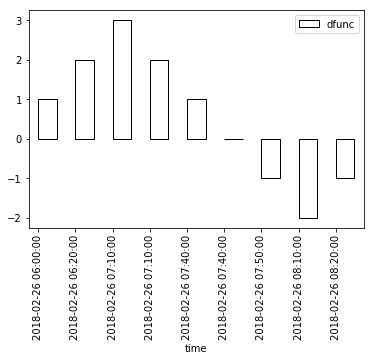

In [22]:
df_a.plot(x="time", y="dfunc", kind="bar", align="edge", facecolor="none", edgecolor="k")

In [54]:
df2 = pd.read_csv("AS2-2.csv")
df2

,trip,veh,dep_time,dep_term,arr_time,arr_term
0,1,1,06:00,a,06:30,c
1,2,2,06:20,a,06:50,b
2,3,4,06:20,b,06:50,c
3,4,3,06:40,d,07:10,a
4,5,1,07:10,a,07:40,a
5,6,2,07:10,b,07:40,a
6,7,3,07:20,d,07:50,a
7,8,1,07:40,c,08:10,a
8,9,4,07:50,d,08:10,b
9,10,4,08:00,b,08:30,c


# 3. Crew Scheduling Problem

In [119]:
df = pd.read_csv("AS2-3.csv")
df.head()

,trip,time,dir
0,1,06:00,dep
1,2,06:00,dep
2,3,06:00,dep
3,4,06:05,dep
4,5,06:10,dep


In [120]:
# convert data format and sort by trip (equivalent to by time)
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(by="trip").reset_index(drop=True)
df.head()

,trip,time,dir
0,1,2018-02-27 06:00:00,dep
1,2,2018-02-27 06:00:00,dep
2,3,2018-02-27 06:00:00,dep
3,4,2018-02-27 06:05:00,dep
4,5,2018-02-27 06:10:00,dep


## 3.a CSP using FIFO principle

In [122]:
# subset only trips in the hollow segment
df2 = df.iloc[11:47,].reset_index(drop=True)
df2.head()

,trip,time,dir
0,12,2018-02-27 06:25:00,arr
1,13,2018-02-27 06:30:00,arr
2,14,2018-02-27 06:30:00,arr
3,15,2018-02-27 06:30:00,arr
4,16,2018-02-27 06:35:00,arr


In [115]:
# calculate joinings by applying FIFO
Tmax = 35
DA = []
DD = []
UJ = []
PJ = []

for i,d in enumerate(df2["dir"]):
    t = df2["time"][i]
    
    if d == "arr":
        DA.append(t)
        
    if d == "dep":
        up_join = "Join {} to {}".format(str(DA[0])[12:-3], str(t)[12:-3])
        diff = (t - DA[0]) / np.timedelta64(1, 'm')
        print(up_join, "; idle:", str(diff)[:-2], "mins")
        
        if diff >= Tmax:
            UJ.append(up_join)
        else:
            PJ.append(up_join)
            
        DA.pop(0)

Join 6:25 to 6:40 ; idle: 15 mins
Join 6:30 to 6:45 ; idle: 15 mins
Join 6:30 to 6:45 ; idle: 15 mins
Join 6:30 to 7:05 ; idle: 35 mins
Join 6:35 to 7:05 ; idle: 30 mins
Join 6:35 to 7:10 ; idle: 35 mins
Join 6:50 to 7:20 ; idle: 30 mins
Join 6:55 to 7:25 ; idle: 30 mins
Join 6:55 to 7:25 ; idle: 30 mins
Join 6:55 to 7:40 ; idle: 45 mins
Join 7:00 to 7:45 ; idle: 45 mins
Join 7:15 to 7:45 ; idle: 30 mins
Join 7:15 to 7:50 ; idle: 35 mins
Join 7:30 to 7:50 ; idle: 20 mins
Join 7:35 to 7:50 ; idle: 15 mins
Join 7:35 to 7:55 ; idle: 20 mins
Join 7:35 to 7:55 ; idle: 20 mins
Join 7:35 to 7:55 ; idle: 20 mins


In [116]:
UJ

['Join 6:30 to 7:05',
 'Join 6:35 to 7:10',
 'Join 6:55 to 7:40',
 'Join 7:00 to 7:45',
 'Join 7:15 to 7:50']

In [118]:
PJ

['Join 6:25 to 6:40',
 'Join 6:30 to 6:45',
 'Join 6:30 to 6:45',
 'Join 6:35 to 7:05',
 'Join 6:50 to 7:20',
 'Join 6:55 to 7:25',
 'Join 6:55 to 7:25',
 'Join 7:15 to 7:45',
 'Join 7:30 to 7:50',
 'Join 7:35 to 7:50',
 'Join 7:35 to 7:55',
 'Join 7:35 to 7:55',
 'Join 7:35 to 7:55']

## 3.b CSP using *TmF* algorithm
## (under development)

In [113]:
#crew = 11
Tmax = 35
DA = []
DD = []
UJ = []
PJ = []

for i,d in enumerate(df2["dir"]):
    t = df2["time"][i]
    
    if d == "arr":
        #crew +=1
        DA.append(t)
        
    if d == "dep":
        if len(DA) > 0:
            if (t - DA[0]) / np.timedelta64(1, 'm') >= Tmax:
                up_join = "Join {} to {}".format(str(DA[0])[12:-3], str(t)[12:-3])
                diff = (t - DA[0]) / np.timedelta64(1, 'm')
                print(up_join, "; idle:", str(diff)[:-2], "mins")
                UJ.append(up_join)
                DA.pop(0)
                print(len(DA), len(DD))
            else:
                DD.append(t)
        else:
            DD.append(t)

# control element for hollow identification,
# if the remaining # of DAs before an unfilled hollow
# is equal to the DD in the hollow,
# those DAs need to be preserved for final FIFO matching

Join 6:25 to 7:05 ; idle: 40 mins
10 3
Join 6:30 to 7:05 ; idle: 35 mins
9 3
Join 6:30 to 7:10 ; idle: 40 mins
8 3
Join 6:30 to 7:20 ; idle: 50 mins
9 3
Join 6:35 to 7:25 ; idle: 50 mins
8 3
Join 6:35 to 7:25 ; idle: 50 mins
7 3
Join 6:50 to 7:40 ; idle: 50 mins
11 3
Join 6:55 to 7:45 ; idle: 50 mins
10 3
Join 6:55 to 7:45 ; idle: 50 mins
9 3
Join 6:55 to 7:50 ; idle: 55 mins
8 3
Join 7:00 to 7:50 ; idle: 50 mins
7 3
Join 7:15 to 7:50 ; idle: 35 mins
6 3
Join 7:15 to 7:55 ; idle: 40 mins
5 3


## 3.c Comparison